[nltk_data] Downloading package punkt to
[nltk_data]     /Users/fangyuanyu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2565


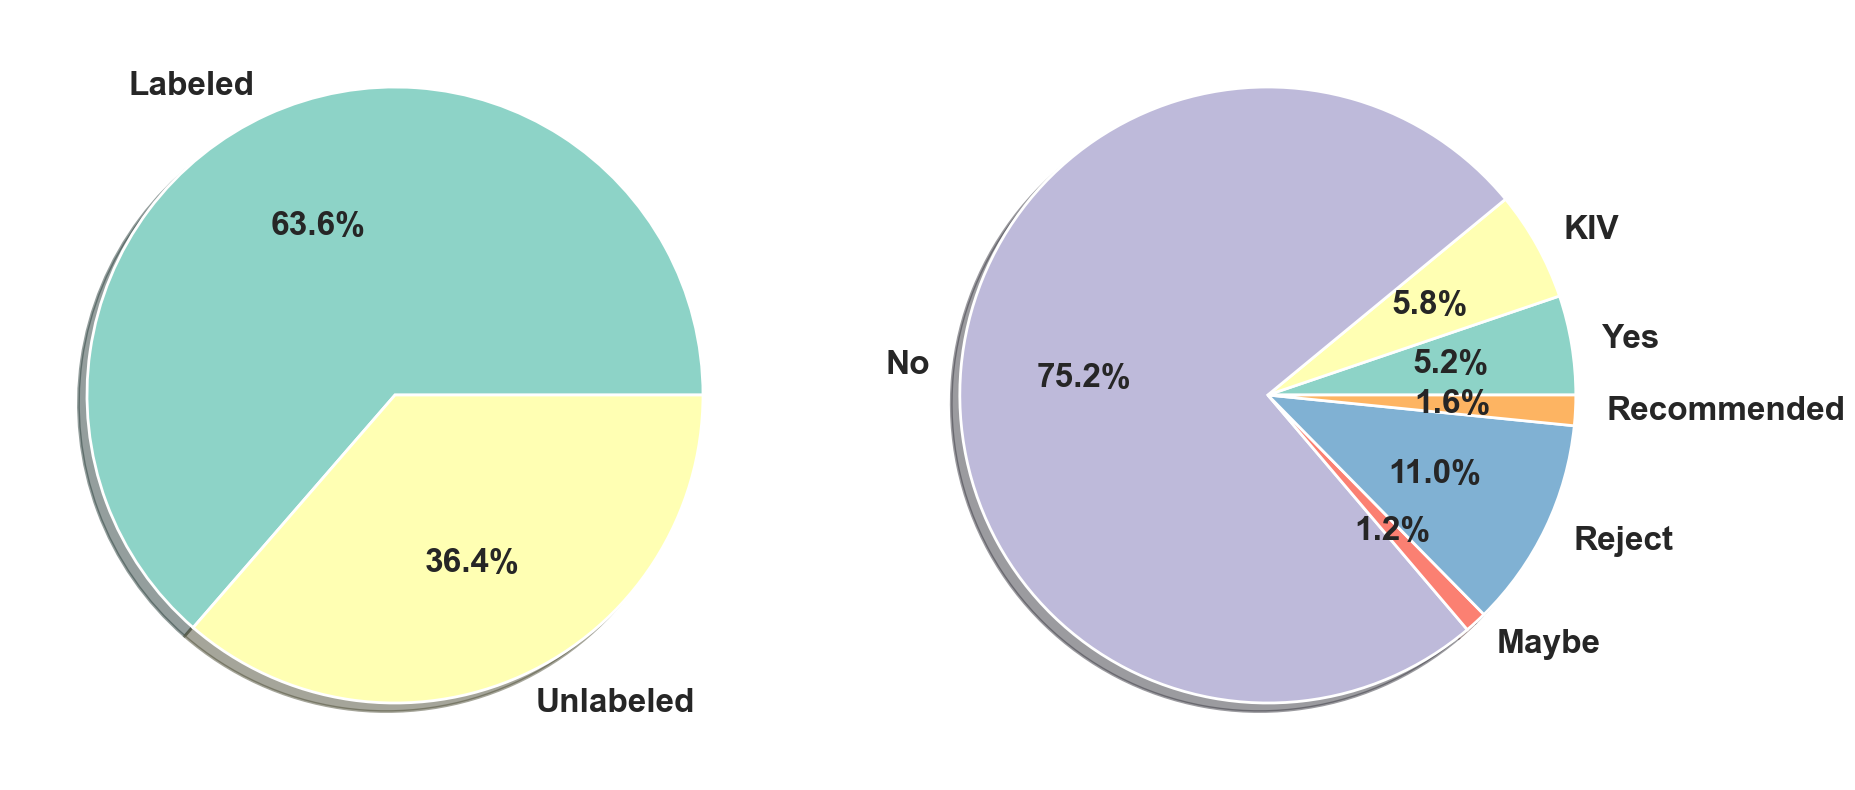

<module 'matplotlib.pyplot' from '/opt/homebrew/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

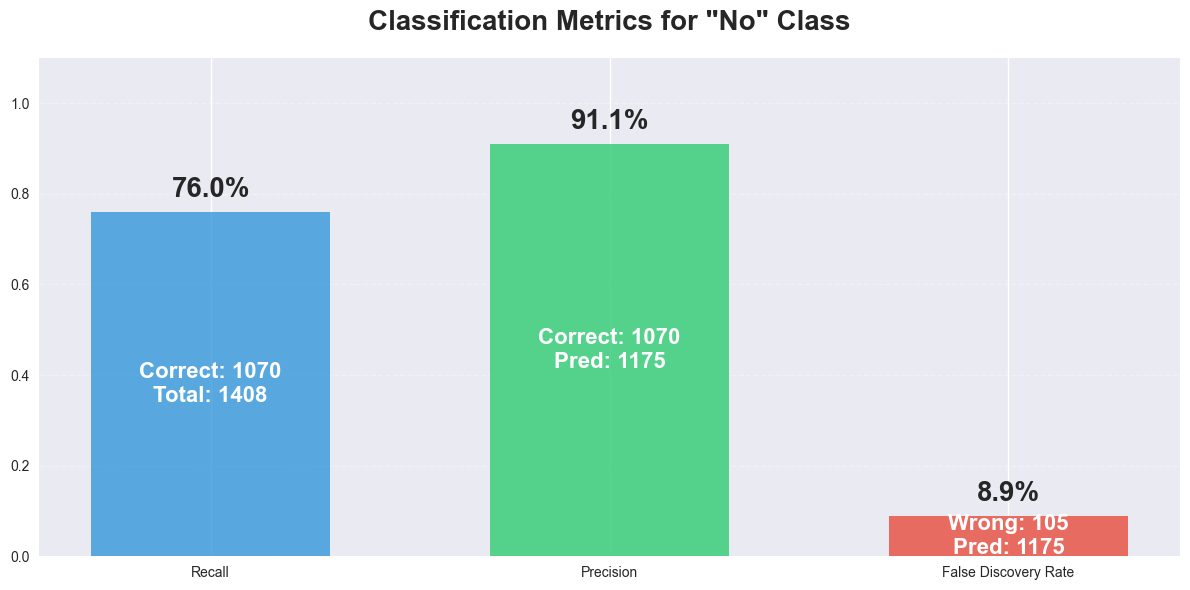

In [1]:
# Load the json data from ../data/data.json and see how many entries there are
from utils import *
import json 

# Read raw data
with open("../data/temasek_grant_data.json") as f:
    raw_data = json.load(f)
    print(len(raw_data))
    
    
data = filter_data_with_label(raw_data, label_key, yes_label_list + no_label_list + neutral_label_list)
labeled_ratio = len(data) / len(raw_data)

label_counts = get_unique_value_count(data, label_key)
positive_comment_counts = get_unique_value_count(data, comment_key, label_key, yes_label_list)
negative_comment_counts = get_unique_value_count(data, comment_key, label_key, no_label_list)

plot_pie_chart(labeled_ratio, label_counts)

metric_dict = calculate_metrics(data, predict_key, label_key)
plot_metrics(metric_dict)

Could not load vllm class, check CUDA support and GPU RAM size


Processing batch of 76 queries: 100%|██████████| 76/76 [00:09<00:00,  7.86it/s]


 :: Total time elapsed: 9.68s, 23 errors


Processing batch of 56 queries: 100%|██████████| 56/56 [00:05<00:00, 10.69it/s]


 :: Total time elapsed: 34.13s, 0 errors


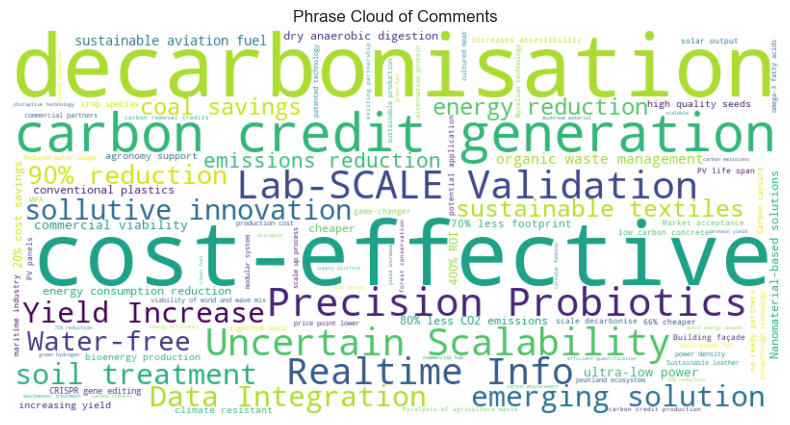

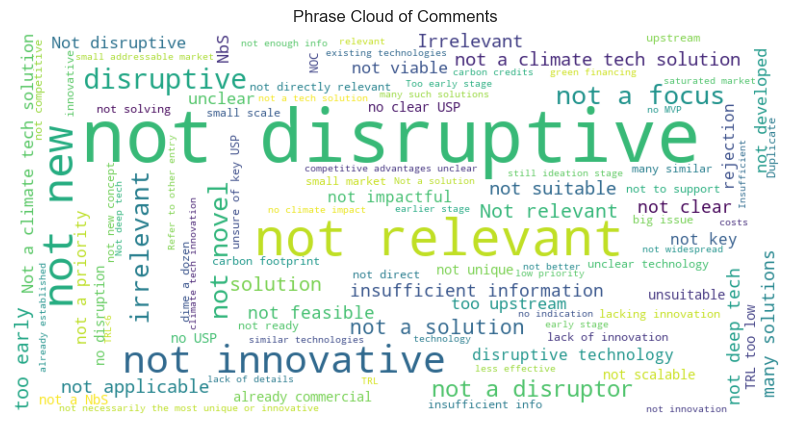

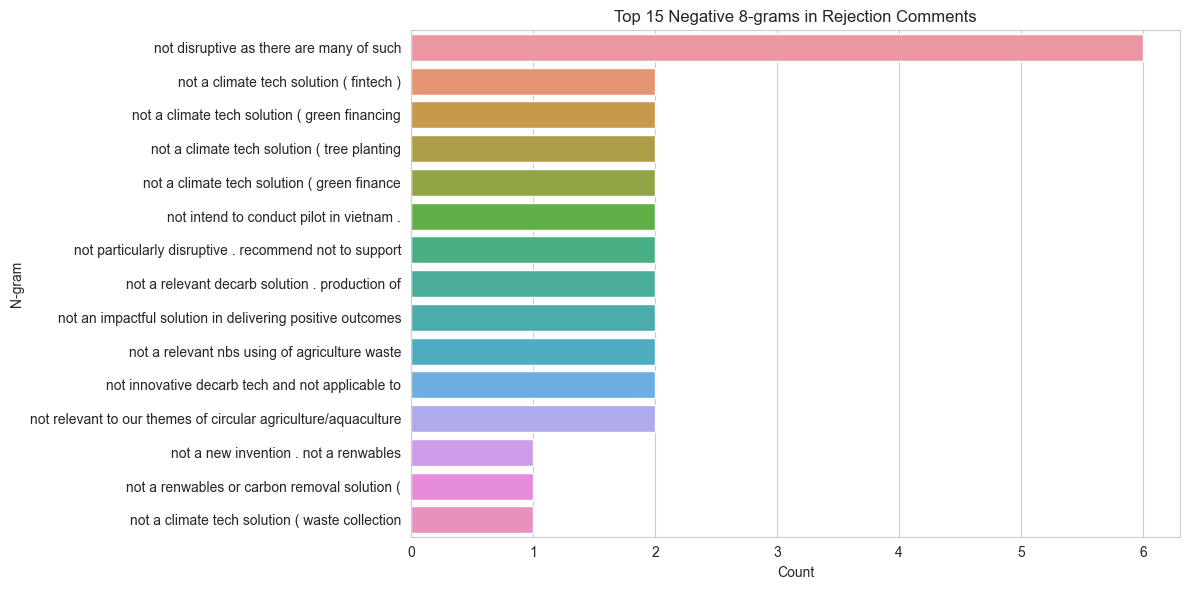

In [2]:
# LLM based key-word extraction
import sys
sys.path.append("../eoh/")
from methods.llm import get_async_vllm_endpoint, get_async_vllm_endpoint_
from methods.meta_prompt import extract_json_from_text
import os 

# Unlimited LLM endpoints
endpoint_id = "vllm-8sz1f7zg7oy0ui"
api_key = "rpa_EPOJED42G59S80Y6SKMCOI330EQU4JPPMKV2UD2W7j0uku"
get_endpoint_response = get_async_vllm_endpoint_(endpoint_id, api_key)

# Key-word extraction powered by LLM
positive_keywords = keyword_extraction_with_llm(positive_comment_counts, False, get_endpoint_response, extract_json_from_text)
negative_keywords = keyword_extraction_with_llm(negative_comment_counts, True, get_endpoint_response, extract_json_from_text)

# Plot key-words cloud 
plot_phrases(positive_keywords)
plot_phrases(negative_keywords)

# N-gram insight plots | Comments on rejection is more duplicated than acceptance
n = 8
get_ngram_plots(negative_comment_counts, n, neg_filter=True, top_k = 15)

In [8]:
# yes_label_list = ["Yes", "Recommended"] # meaningful positive signal
# no_label_list = ["No", "No ", "Reject"] # meaningful negative signal


processed_data = {"prompt": [], "label": [], "comment": []}

for i, d in enumerate(data.values()): # comment is probably more important than the decision
    te = make_training_example(d)
    if te is not None:
        processed_data["prompt"].append(te[0])
        processed_data["label"].append(te[1])
        processed_data["comment"].append(te[2])      
        
import json
with open('../data/processed_data.json', 'w') as f:
    json.dump(processed_data, f)
    

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch 

model_name = "Qwen/Qwen2.5-0.5B-Instruct"

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float32,  # Change to float32 instead of "auto"
    device_map="mps"
)
tokenizer = AutoTokenizer.from_pretrained(model_name)


In [2]:
type(model)

transformers.models.qwen2.modeling_qwen2.Qwen2ForCausalLM

In [7]:
# write a class object to add n learnable soft-prompts to the model 
# in the meantime, modify the forward function to include soft-prompt embeddings
import torch.nn as nn 

class SoftPromptLLM(nn.Module): 
    
    def __init__(self, model, tokenizer, n_learnable_tokens, initialize_from_vocab=False):
        super().__init__()
        self.model = model 
        self.tokenizer = tokenizer 
        self.n_learnable_tokens = n_learnable_tokens
        
        # Get embedding dimension from model
        embedding_size = model.get_input_embeddings().weight.shape[1]
        
        # Get the device from the model
        self.device = next(model.parameters()).device
        
        # Initialize soft prompts
        if initialize_from_vocab:
            # Initialize from random vocabulary tokens
            init_prompt_ids = torch.randint(len(tokenizer), (n_learnable_tokens,))
            init_prompt_ids = init_prompt_ids.to(self.device)
            self.soft_prompts = nn.Parameter(
                model.get_input_embeddings()(init_prompt_ids),
                requires_grad=True
            )
        else:
            # Random initialization
            self.soft_prompts = nn.Parameter(
                torch.randn(n_learnable_tokens, embedding_size, device=self.device),
                requires_grad=True
            )
            
        # freeze other model parameters
        for param in self.model.parameters():
            param.requires_grad = False 
    
    def forward(self, input_ids, attention_mask=None, labels=None, **kwargs):
        
        batch_size = input_ids.shape[0]
        
        # Expand soft prompts for batch size
        soft_prompts = self.soft_prompts.unsqueeze(0).expand(batch_size, -1, -1)
        
        # Get input embeddings
        inputs_embeds = self.model.get_input_embeddings()(input_ids)
        
        # Concatenate soft prompts with input embeddings
        inputs_embeds = torch.cat([soft_prompts, inputs_embeds], dim=1)
        
        # Adjust attention mask if provided
        if attention_mask is not None:
            prefix_mask = torch.ones(batch_size, self.n_learnable_tokens).to(attention_mask.device)
            attention_mask = torch.cat([prefix_mask, attention_mask], dim=1)
            
        # Adjust labels if provided
        if labels is not None: 
            prefix_labels = torch.full((batch_size, self.n_learnable_tokens), -100, dtype=labels.dtype).to(labels.device)
            labels = torch.cat([prefix_labels, labels], dim=1)
        
        # Forward pass through model
        outputs = self.model(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask,
            labels=labels,
            **kwargs
        )
        
        return outputs
    
model_with_soft_prompt = SoftPromptLLM(model, tokenizer, 3, initialize_from_vocab=True)

In [6]:
model_with_soft_prompt

SoftPromptLLM(
  (model): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151936, 896)
      (layers): ModuleList(
        (0-23): 24 x Qwen2DecoderLayer(
          (self_attn): Qwen2SdpaAttention(
            (q_proj): Linear(in_features=896, out_features=896, bias=True)
            (k_proj): Linear(in_features=896, out_features=128, bias=True)
            (v_proj): Linear(in_features=896, out_features=128, bias=True)
            (o_proj): Linear(in_features=896, out_features=896, bias=False)
            (rotary_emb): Qwen2RotaryEmbedding()
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
            (up_proj): Linear(in_features=896, out_features=4864, bias=False)
            (down_proj): Linear(in_features=4864, out_features=896, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMS

In [18]:
embedding_size = model.get_input_embeddings().weight.shape[0]
print(embedding_size)

151936


In [19]:
# Initialize soft prompt embeddings


n_tokens = 3 
initialize_from_vocab = False 

import torch.nn as nn 

if initialize_from_vocab:
    # Initialize from random vocabulary tokens
    init_prompt_ids = torch.randint(len(tokenizer), (n_tokens,))
    soft_prompt = nn.Parameter(
        model.get_input_embeddings()(init_prompt_ids),
        requires_grad=True
    )
else:
    # Random initialization
    soft_prompt = nn.Parameter(
        torch.randn(n_tokens, embedding_size),
        requires_grad=True
    )
